<a href="https://colab.research.google.com/github/PauloGunther/project_pos/blob/main/tcc_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introdução

### Considerações iniciais
O trabalho visa comparar o desemprenho de tres modelos de machine learning para prever os preços dos imóveis em Goinia-GO: SARIMAX - Modelo estatistico para séries temperais, XGBoost - Ensemble sequencial de arvores de decisão e LSTM - Rede neural para dados sequencias de longo prazo.

Para isso serão usados como variaveis indepentes 10 inidicadores macroeconomicos:

dolar - Média mensal de compra

tx_juros - Taxa média de juros das operações de crédito

ipca - Índice nacional de preços ao consumidor-amplo

renda_med - Rendimento médio real habitual das pessoas ocupadas

ocupado_rend - População ocupada com rendimento

incc - Indice de custo de construção geral (Mão de obra + Material)

ic_agro - Indice de preços de commodities focado apenas em agricolas

inadim_imob - inadimplencia imobiliaria PJ e PF

sald_cred - Saldo da carteira de crédito com recursos direcionados

vol_cred - Volume da carteira de crédito com recursos direcionados

## 1.2 Bibliotecas usadas e importação dos dados

In [265]:
# Bibliotecas gerais
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
import random
import itertools

# BIbliotecas de Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Padronizar/Normalizar features
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split  # Divisao de dados
from statsmodels.tsa.stattools import ccf # para calcular a correlação cruzada

# Bibliotecas ARIMA
from statsmodels.tsa.stattools import adfuller # Teste de estacionariedade
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Autocorreções
from statsmodels.tsa.statespace.sarimax import SARIMAX # Modelo
import statsmodels.api as sm

# Bibliotecas XGBoost
import xgboost as xgb # Modelo
import shap # Peso das variaveis
from sklearn import tree # Visualizar arvore de decisao
from sklearn.model_selection import TimeSeriesSplit # Validação cruzada em séries temporais

# Bibliotecas Rede Neural
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.optimizers import Adam

# Outras
import warnings
import os
warnings.filterwarnings('ignore')

In [266]:
# Importar dataframe já pré-processado
url = "https://github.com/PauloGunther/project_pos/raw/refs/heads/main/df_pre_model.pkl"

df_pre_pro = pd.read_pickle(url)
df_pre_pro.tail()

,date,go_price,tx_juros,ipca,renda_med,ocupado_rend,incc,ic_agro,inadim_imob,vol_cred,sald_cred
133,2025-02-01,7974.0,30.56,5.057630,3335.0,99291.0,7.419134,510.22,1.146447,20534.0,1250719.0
134,2025-03-01,7982.0,31.25,5.477190,3347.0,99213.0,7.536965,484.87,1.206241,20244.0,1263677.0
135,2025-04-01,7936.0,31.53,5.529729,3331.0,99972.0,7.536965,494.59,1.234180,21813.0,1276366.0
136,2025-05-01,7905.0,31.56,5.319636,3342.0,100585.0,7.238429,491.25,1.241216,21979.0,1289912.0
137,2025-06-01,7886.0,31.52,5.351165,3369.0,101004.0,7.217132,476.21,1.121180,21873.0,1300442.0


In [267]:
# Transforma feature datetime em indice
df_pre_pro.set_index('date', inplace=True)

In [268]:
df_pre_pro.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 2014-01-01 to 2025-06-01
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   go_price      138 non-null    float64
 1   tx_juros      138 non-null    float64
 2   ipca          138 non-null    float64
 3   renda_med     138 non-null    float64
 4   ocupado_rend  138 non-null    float64
 5   incc          138 non-null    float64
 6   ic_agro       138 non-null    float64
 7   inadim_imob   138 non-null    float64
 8   vol_cred      138 non-null    float64
 9   sald_cred     138 non-null    float64
dtypes: float64(10)
memory usage: 11.9 KB


# 2. SARIMAX


## 2.1 Análise da variavel dependente
Avaliando o preço do metro quadrado dos imóveis em Goiânia, observa-se que se trata de uma série temporal não estacionária, pois as principais estatísticas se alteram ao longo do tempo. O teste de estacionariedade de Dickey-Fuller confirmou essa característica, pois o nível de significância foi maior que 0,05, rejeitando a hipótese nula da série ser estacionaria. Assim, foram necessárias duas diferenciações para tornar a série estacionária, o que sugere o uso do parâmetro d=2 no modelo SARIMAX.

Em relação às funções de autocorrelação [ACF] e autocorrelação parcial [PACF], observou-se um declínio acentuado logo no primeiro “lag”, embora os valores iniciais tenham permanecido fora do intervalo de confiança, como observado na Figura 8 e Figura 9, respectivamente. O retorno aos limites de confiança ocorreu a partir do segundo “lag” em ambas as funções, indicando a possibilidade de adoção dos parâmetros p=2 e q=2 no modelo.


In [269]:
# Copiando df pré processado
df_sarimax = df_pre_pro.copy()

In [270]:
# Separando df em y e X
y = df_sarimax['go_price']  # preço dos imóveis R$/m²
X = df_sarimax.drop(columns=['go_price'])  # variáveis exógenas

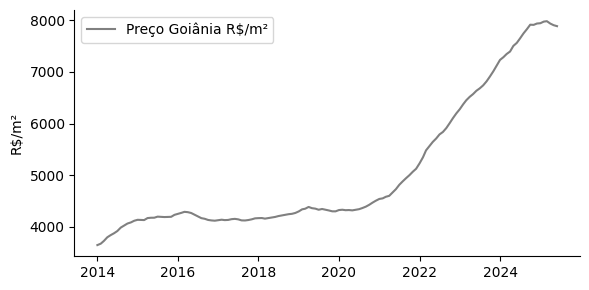

In [271]:
# Tamanho da figura
plt.figure(figsize=(6, 3))

# Plot da segunda série
plt.plot(df_sarimax.index, df_sarimax['go_price'], label='Preço Goiânia R$/m²', color ='grey')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()

In [272]:
# Teste de estacionariedade do preço (Augmented Dickey-Fuller)
result = adfuller(y)
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print('Não estacionária')
else:
    print('Estacionária')

p-value: 0.39987539806678524
Não estacionária


In [273]:
# Diferenciação multipla d=2
y_diff = y.diff().diff().dropna()

# Teste de estacionariedade do preço
result = adfuller(y_diff)
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print('Não estacionária')
else:
    print('Estacionária')

p-value: 2.341470663882069e-09
Estacionária


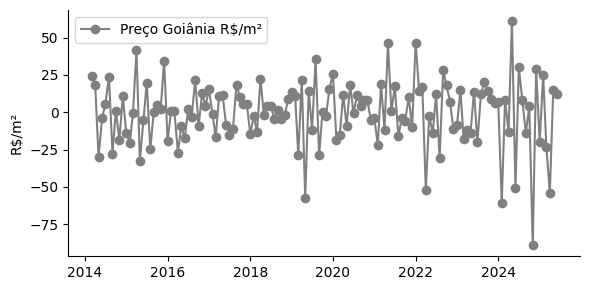

In [274]:
# Plot da série diferenciada d=2
plt.figure(figsize=(6, 3))

# Plot da segunda série
plt.plot(y_diff, marker='o', label='Preço Goiânia R$/m²', color ='grey')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()

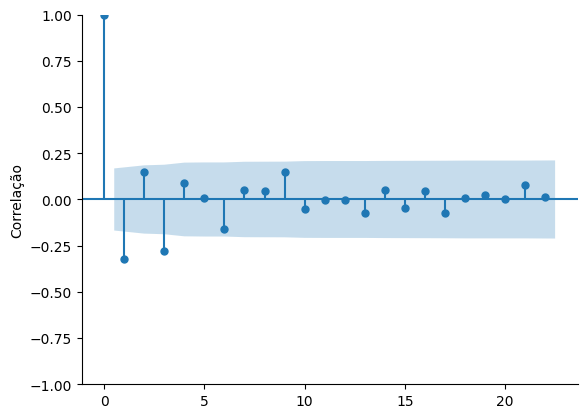

In [275]:
# Autocorrelação
plot_acf(y_diff, alpha = 0.05)

# Opções dos eixos
plt.ylabel('Correlação', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Titulo
plt.title('')

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

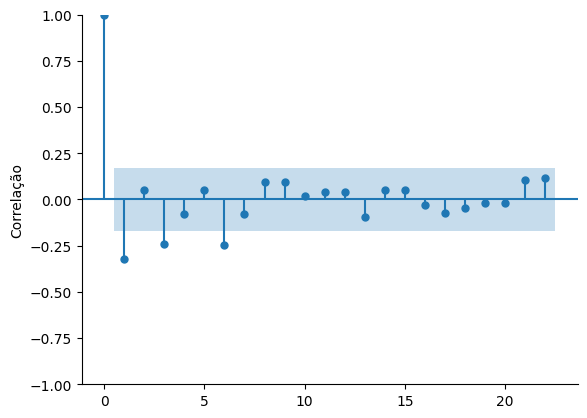

In [276]:
# Autocorrelação parcial
plot_pacf(y_diff, alpha = 0.05)

# Opções dos eixos
plt.ylabel('Correlação', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Titulo
plt.title('')

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## 2.2 Ajustes variaveis independetes
Todas as dez variáveis explicativas foram testadas quanto à estacionariedade e precisaram ser diferenciadas antes de sua inclusão no modelo. Algumas variaveis precisaram uma segunda diferenciação.

Foram criadas variaveis defasadas 3 períodos e eliminado as variaveis contemporaneas a variavel resposta para não haver dataleakage.

Essas variaveis foram padronizadas usando o Z scaler, para os coeficientes poderem ser comparados, já que na forma orginal existe uma grande diferença de escalas.

Aqui foi definido o tamanho da amostra de teste (previsão) do modelo: 12 meses


In [277]:
# Teste de estacionaridade para cada uma das variaveis
for col in X.columns:
    result = adfuller(X[col])
    print(f'{col}: p-value = {result[1]}')

tx_juros: p-value = 0.14998490660175418
ipca: p-value = 0.11315675549840526
renda_med: p-value = 0.6296463779813326
ocupado_rend: p-value = 0.8137847449285941
incc: p-value = 0.21389747647989443
ic_agro: p-value = 0.9563702022551306
inadim_imob: p-value = 0.5071560158076804
vol_cred: p-value = 0.6979836820124001
sald_cred: p-value = 0.9987630432310369


In [278]:
# Diferenciar todas variaveis p-valor
X_copy = X.copy()

for col in X_copy.columns:
    X_copy[col] = X_copy[col].diff()

# Eliminar NaN
X_copy.dropna(inplace=True)

# Printar p-value ADF
for col in X_copy.columns:
    result = adfuller(X_copy[col])
    print(f'{col}: p-value = {result[1]}')


tx_juros: p-value = 0.06966866763262801
ipca: p-value = 0.011857680063458177
renda_med: p-value = 0.00016455957657795245
ocupado_rend: p-value = 0.030405756794609523
incc: p-value = 0.004381916362340789
ic_agro: p-value = 3.224569435680265e-16
inadim_imob: p-value = 2.3806899126309537e-07
vol_cred: p-value = 0.1519602745434337
sald_cred: p-value = 0.758402015445268


In [279]:
# Diferenciar novamente variaveis que nao passaram no ADF
X_copy['tx_juros'] = X_copy['tx_juros'].diff()
X_copy['vol_cred'] = X_copy['vol_cred'].diff()
X_copy['sald_cred'] = X_copy['sald_cred'].diff()

# Eliminar NaN
X_copy.dropna(inplace=True)

# Printar p-value ADF
for col in X_copy.columns:
    result = adfuller(X_copy[col])
    print(f'{col}: p-value = {result[1]}')

tx_juros: p-value = 0.0012499029416097108
ipca: p-value = 0.01029989264953793
renda_med: p-value = 0.0002615694026597388
ocupado_rend: p-value = 0.03065757787607261
incc: p-value = 0.0048215899000907565
ic_agro: p-value = 4.1485159783496053e-16
inadim_imob: p-value = 4.022887989093997e-07
vol_cred: p-value = 1.1881083198127637e-10
sald_cred: p-value = 0.1929213697594529


In [280]:
# Criar variaveis com lag

# Número de lags
lags = 3  # Lag

# Lag features
for col in X_copy.columns.tolist():
    for lag in range(1, lags + 1):
        X_copy[f'{col}_lag_{lag}'] = X_copy[col].shift(lag)

# Remover linhas com NaN (criadas pelos lags)
X_copy = X_copy.dropna()

# Excluir features no lag=0 - Evitar dataleakage
X_copy = X_copy.drop(columns=X.columns.tolist())

In [281]:
# Padronizar variaveis X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_copy)
X_scaled

# Manter nomes originais
X_scaled = pd.DataFrame(X_scaled, columns=X_copy.columns, index=X_copy.index)
X_scaled.tail(10)

,tx_juros_lag_1,tx_juros_lag_2,tx_juros_lag_3,ipca_lag_1,ipca_lag_2,ipca_lag_3,renda_med_lag_1,renda_med_lag_2,renda_med_lag_3,ocupado_rend_lag_1,...,ic_agro_lag_3,inadim_imob_lag_1,inadim_imob_lag_2,inadim_imob_lag_3,vol_cred_lag_1,vol_cred_lag_2,vol_cred_lag_3,sald_cred_lag_1,sald_cred_lag_2,sald_cred_lag_3
date,,,,,,,,,,,,,,,,,,,,,
2024-09-01,-0.060767,-0.155661,0.212600,-0.471650,0.512619,0.562726,0.760734,-0.828659,0.937944,0.565930,...,2.157166,-0.003610,-0.259130,-0.694487,-0.064813,0.266424,-0.997711,0.041146,0.404132,-0.447783
2024-10-01,-0.060767,-0.060584,-0.155853,0.361722,-0.476512,0.505257,-0.534499,0.766444,-0.841325,0.636954,...,0.420472,-0.294439,-0.009209,-0.258039,-0.518978,-0.070430,0.280502,0.065432,0.041854,0.402885
2024-11-01,0.818740,-0.060584,-0.060768,0.633846,0.357121,-0.481001,0.611284,-0.529577,0.740247,0.718335,...,-1.287856,-0.050043,-0.299332,-0.008091,-0.070725,-0.524905,-0.054178,-0.584021,0.066145,0.040587
2024-12-01,-0.060767,0.818874,-0.060768,0.227297,0.629331,0.350211,0.511651,0.616903,-0.544780,0.358778,...,0.961245,0.181047,-0.055529,-0.298245,-0.311022,-0.076346,-0.505719,-0.138909,-0.583443,0.064880
2025-01-01,-0.464864,-0.060584,0.818765,-0.064201,0.222654,0.621630,0.760734,0.517209,0.591975,-0.281914,...,1.272349,-0.983485,0.175001,-0.054415,1.082772,-0.316807,-0.060055,-0.580671,-0.138239,-0.584744
2025-02-01,1.484313,-0.464660,-0.060768,-0.491704,-0.068935,0.216135,0.910184,0.766444,0.493127,-1.387219,...,2.094030,0.293618,-0.986704,0.176139,-1.051040,1.077936,-0.298964,-0.364186,-0.580092,-0.139515
2025-03-01,-0.845192,1.484409,-0.464878,0.939803,-0.496572,-0.074608,0.710918,0.915984,0.740247,-0.594122,...,3.504979,0.169024,0.287298,-0.985693,1.262560,-1.057329,1.086775,0.773926,-0.363563,-0.581394
2025-04-01,0.081856,-0.844966,1.484357,0.794272,0.935384,-0.501003,0.511651,0.716597,0.888520,-0.252321,...,0.331716,0.352449,0.163006,0.288448,-0.646951,1.257847,-1.034706,0.466159,0.774786,-0.364852
2025-05-01,-0.488635,0.082030,-0.845217,0.111215,0.789807,0.926794,-0.883216,0.517209,0.690823,0.986153,...,-2.745471,0.177369,0.345986,0.164143,0.644603,-0.652965,1.265525,-0.128022,0.466955,0.773560


In [282]:
print(y_diff.shape, X_scaled.shape)

(136,) (133, 27)


## 2.3 Modelo Inicial
Seguindo os parâmetros sugeridos pela analisa temporal da variavel independete.



In [283]:
# Tamanho da previsão
test_size = 12

# Ajuste do tabalho do teste
train_size = len(X_scaled)-test_size

In [284]:
# Igualar tamanhos
ajuste = 5
y_diff = y.iloc[ajuste:]
y_diff

,go_price
date,
2014-06-01,3878.864958
2014-07-01,3921.615472
2014-08-01,3988.293665
2014-09-01,4027.250054
2014-10-01,4067.136438
...,...
2025-02-01,7974.000000
2025-03-01,7982.000000
2025-04-01,7936.000000


In [285]:
# Dividir em teste e treino
X_train, X_test = X_scaled.iloc[:-test_size], X_scaled.iloc[-test_size:]
y_train, y_test = y_diff.iloc[:-test_size], y_diff.iloc[-test_size:]

In [286]:
# Instanciando Modelo SARIMAX Inicial
modelo_arima_inicial = SARIMAX(
    y_train,
    exog=X_train,
    order=(2, 2, 2),
    seasonal_order=(1, 2, 1, 12)    # Com sazonalidade
)

# Rodar modelo
resultado_inicial = modelo_arima_inicial.fit()
print(resultado_inicial.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             go_price   No. Observations:                  121
Model:             SARIMAX(2, 2, 2)x(1, 2, [1], 12)   Log Likelihood                -427.928
Date:                              Sun, 07 Sep 2025   AIC                            923.857
Time:                                      20:27:44   BIC                           1010.689
Sample:                                  06-01-2014   HQIC                           958.943
                                       - 06-01-2024                                         
Covariance Type:                                opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
tx_juros_lag_1         1.0160      2.237      0.454      0.650      -3.369       5

In [287]:
# Predição do modelo SARIMAX
forecast_steps = len(X_test)
forecast_inicial = resultado_inicial.get_forecast(steps=forecast_steps,
                              exog=X_test)

# Predição
y_pred_init_sarimax = forecast_inicial.predicted_mean

# Retorando valores reais
y_true_test = y.iloc[-len(y_pred_init_sarimax):]

# Calcular RMSE
rmse_inicial = sqrt(mean_squared_error(y_true_test, y_pred_init_sarimax))
print(f'RMSE: {rmse_inicial:.2f} - LL: {resultado_inicial.llf:.2f} - AIC: {resultado_inicial.aic:.2f}')


RMSE: 401.13 - LL: -427.93 - AIC: 923.86


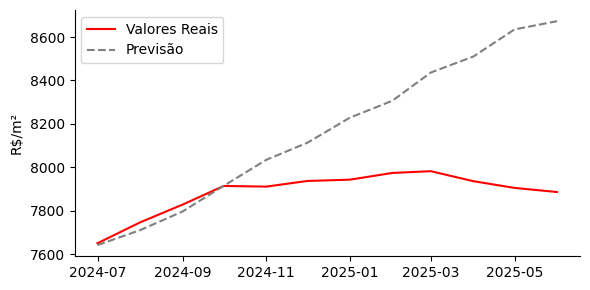

In [288]:
# Criar figura
plt.figure(figsize=(6, 3))

# Plotar valores reais
plt.plot(y_test.index, y_true_test, 'r-', label='Valores Reais')

# Plotar valores previstos
plt.plot(y_test.index, y_pred_init_sarimax, '--', color='grey', label='Previsão')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()


## 2.4 Modelo com Grid Search - RMSE

Foi criado uma função para combinar parametros e encontrar o melhor RMSE. Foi criado um arquivo de funções chamado gridsearch e está sendo puxado do github.

Modelo rodado e realizado previsão do modelo.

Resultados de erro melhor que o modelo inicial.


In [289]:
# Puxando arquivo de funções gridsearch criado
!wget https://github.com/PauloGunther/project_pos/raw/refs/heads/main/gridsearch.py -O gridsearch.py

--2025-09-07 20:27:44--  https://github.com/PauloGunther/project_pos/raw/refs/heads/main/gridsearch.py
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PauloGunther/project_pos/refs/heads/main/gridsearch.py [following]
--2025-09-07 20:27:44--  https://raw.githubusercontent.com/PauloGunther/project_pos/refs/heads/main/gridsearch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14841 (14K) [text/plain]
Saving to: ‘gridsearch.py’

gridsearch.py       100%[===================>]  14.49K  --.-KB/s    in 0s      

2025-09-07 20:27:44 (84.2 MB/s) - ‘gridsearch.py’ saved [14841/14841]



In [290]:
# Importando funções gridsearch RMSE e AIC
import gridsearch

In [291]:
# Gridsearch procurando melhor RMSE

#Função comentada pois demora para rodar

"""
gridsearch.sarimax_gridsearch_rmse(y, y_train, y_test, exog_train=X_train, exog_test=X_test,
                           p_values=range(1, 3), d_values=range(1, 3), q_values=range(1, 3),
                           P_values=range(0, 3), D_values=range(0, 3), Q_values=range(0, 3),
                           seasonal_period=12)
"""

'\ngridsearch.sarimax_gridsearch_rmse(y, y_train, y_test, exog_train=X_train, exog_test=X_test,\n                           p_values=range(1, 3), d_values=range(1, 3), q_values=range(1, 3),\n                           P_values=range(0, 3), D_values=range(0, 3), Q_values=range(0, 3),\n                           seasonal_period=12)\n'

In [292]:
# 2º Modelo SARIMAX - Grid Search - RMSE

"""
Top 5 melhores modelos por RMSE:
    order seasonal_order       rmse  log_likelihood         aic         bic
(1, 1, 1)  (2, 0, 0, 12) 102.444091     -499.497258 1062.994516 1152.194251
(1, 1, 1)  (2, 0, 1, 12) 110.933277     -499.894191 1065.788382 1157.775610
(1, 1, 1)  (0, 0, 0, 12) 114.933928     -499.873783 1059.747566 1143.372318
(1, 1, 1)  (0, 0, 1, 12) 115.336388     -499.981650 1061.963300 1148.375544
(1, 1, 1)  (1, 0, 0, 12) 117.183356     -499.972665 1061.945329 1148.357573
"""

# Modelo com o menor erro (RMSE)
modelo_arima_gs = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 1, 1),
    seasonal_order=(2, 0, 0, 12))

# Treinar
resultado_gs = modelo_arima_gs.fit()
print(resultado_gs.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            go_price   No. Observations:                  121
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 12)   Log Likelihood                -499.497
Date:                             Sun, 07 Sep 2025   AIC                           1062.995
Time:                                     20:27:52   BIC                           1152.194
Sample:                                 06-01-2014   HQIC                          1099.219
                                      - 06-01-2024                                         
Covariance Type:                               opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
tx_juros_lag_1        -0.4153      1.548     -0.268      0.788      -3.449       2.619
tx_

In [293]:
# Predição do modelo SARIMAX - Grid Search - RMSE
forecast_steps = len(X_test)
forecast_gs = resultado_gs.get_forecast(steps=forecast_steps,
                              exog=X_test)

# Previsão
y_pred_gs_rmse = forecast_gs.predicted_mean

# Calcular RMSE
rmse_gs = sqrt(mean_squared_error(y_true_test, y_pred_gs_rmse))

print('INICIAL')
print(f'RMSE: {rmse_inicial:.2f} - LL: {resultado_inicial.llf:.2f} - AIC: {resultado_inicial.aic:.2f}')
print('Grid Search RMSE:')
print(f'RMSE: {rmse_gs:.2f} - LL: {resultado_gs.llf:.2f} - AIC: {resultado_gs.aic:.2f}')


INICIAL
RMSE: 401.13 - LL: -427.93 - AIC: 923.86
Grid Search RMSE:
RMSE: 102.44 - LL: -499.50 - AIC: 1062.99


In [294]:
pred_train = resultado_gs.get_prediction(
    start=0,
    end=len(X_train)-1,
    exog=X_train
)

# Valores previstos no treino
y_pred_train = pred_train.predicted_mean

# Calcular RMSE treino
rmse_train = sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Treino:", rmse_train)

RMSE Treino: 352.2358226795491


## 2.4 Modelo com Grid Search - AIC

No mesmo arquivo de função, há uma segundo para combinar parametros e encontrar o melhor AIC.

Modelo rodado e realizado previsão do modelo.

Resultados de erro melhor que o modelo inicial.

COmo este modelo tem a melhor métrica de AIC que combina qualidade e complexidade, evitando overfitting, foi utilizado para avaliar os coeficientes das variaveis independentes e os impactos na variavel resposta.

In [98]:
# Gridsearch procurando melhor AIC
"""
#Função comentado pois demora para rodar
gridsearch.sarimax_gridsearch_AIC(y, y_train, y_test, exog_train=X_train, exog_test=X_test,
                           p_values=range(0, 3), d_values=range(0, 3), q_values=range(0, 3),
                           P_values=range(0, 3), D_values=range(0, 3), Q_values=range(0, 3),
                           seasonal_period=12)
"""


'\n#Função comentado pois demora para rodar\ngridsearch.sarimax_gridsearch_AIC(y, y_train, y_test, exog_train=X_train, exog_test=X_test,\n                           p_values=range(0, 3), d_values=range(0, 3), q_values=range(0, 3),\n                           P_values=range(0, 3), D_values=range(0, 3), Q_values=range(0, 3),\n                           seasonal_period=12)\n'

In [295]:
# Modelo SARIMAX - Grid Search - AIC

"""
(1, 2, 1)  (2, 2, 2, 12)    801.314457     -416.086370 900.172741 987.004555
(2, 2, 2)  (2, 2, 2, 12)    731.104138     -415.040295 902.080590 994.020158
"""

# Modelo com o menor erro (RMSE)
modelo_arima_aic = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 2, 1),
    seasonal_order=(2, 2, 2, 12))

# Treinar
resultado_aic = modelo_arima_aic.fit()
print(resultado_aic.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                go_price   No. Observations:                  121
Model:             SARIMAX(1, 2, 1)x(2, 2, [1, 2], 12)   Log Likelihood                -416.086
Date:                                 Sun, 07 Sep 2025   AIC                            900.173
Time:                                         20:29:08   BIC                            987.005
Sample:                                     06-01-2014   HQIC                           935.259
                                          - 06-01-2024                                         
Covariance Type:                                   opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
tx_juros_lag_1         3.5403      1.698      2.085      0

In [299]:
# Predição do modelo SARIMAX - Grid Search
forecast_steps = len(X_test)
forecast_aic = resultado_aic.get_forecast(steps=forecast_steps,
                              exog=X_test)

# Predição
y_pred_aic = forecast_aic.predicted_mean

# Calcular RMSE
rmse_aic = sqrt(mean_squared_error(y_true_test, y_pred_aic))

## 2.5 Visualização das predições e resultados dos modelos

INICIAL

RMSE: 74.69 - LL: -489.17 - AIC: 1046.34

Grid Search: RMSE

RMSE: 68.34 - LL: -492.58 - AIC: 1053.17

Grid Search: AIC

RMSE: 85.29 - LL: -448.55 - AIC: 963.10

In [298]:
# Visualizar resultados de métricas dos tres modelos SARIMAX

print('INICIAL')
print(f'RMSE: {rmse_inicial:.2f} - LL: {resultado_inicial.llf:.2f} - AIC: {resultado_inicial.aic:.2f}')
print('Grid Search: RMSE')
print(f'RMSE: {rmse_gs:.2f} - LL: {resultado_gs.llf:.2f} - AIC: {resultado_gs.aic:.2f}')
print('Grid Search: AIC')
print(f'RMSE: {rmse_aic:.2f} - LL: {resultado_aic.llf:.2f} - AIC: {resultado_aic.aic:.2f}')

INICIAL
RMSE: 401.13 - LL: -427.93 - AIC: 923.86
Grid Search: RMSE
RMSE: 102.44 - LL: -499.50 - AIC: 1062.99
Grid Search: AIC
RMSE: 801.31 - LL: -416.09 - AIC: 900.17


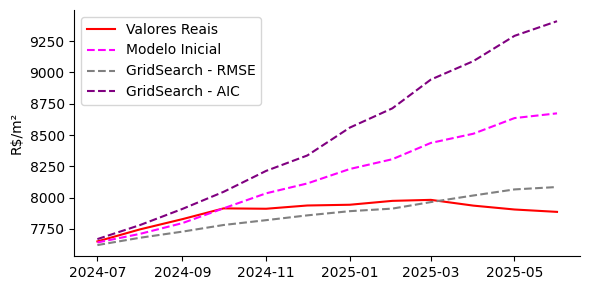

In [102]:
# Criar figura
plt.figure(figsize=(6, 3))

# Plotar valores reais
plt.plot(y_test.index, y_true_test, 'r-', label='Valores Reais')

# Plotar valores previstos
plt.plot(y_test.index, y_pred_init_sarimax, '--', color='magenta', label='Modelo Inicial')
plt.plot(y_test.index, y_pred_gs_rmse, '--',color='grey', label='GridSearch - RMSE')
plt.plot(y_test.index, y_pred_aic, '--', color='purple', label='GridSearch - AIC')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()

# 3. Modelo XGBoost

## 3.1 Tratamentos iniciais

Criado lags

Diferenciado features e target - nao foi usado normalização


In [112]:
# Definir dataframe
df_xgb = df_pre_pro.dropna()

In [113]:
# Criando variaveis com lag
lags =  3 # Lag

# Lag features
X = df_xgb.copy()
for col in X.columns.tolist():
    for lag in range(1, lags + 1):
        X[f'{col}_lag_{lag}'] = X[col].shift(lag)

In [114]:
# Excluir variaivel orginais deixando apenas defasadas
X = X.drop(columns=df_xgb.columns.tolist())

# Diferenciar variaveis independentes
X_xgb = X.diff().dropna()
X_xgb.head()

In [118]:
# Definir variavel dependente
y_xgb = df_xgb['go_price']

# Diferenciação em y
y_xgb_diff = y_xgb.diff().dropna()
y_xgb_diff.head()

,go_price
date,
2014-02-01,27.865400
2014-03-01,52.360131
2014-04-01,70.842366
2014-05-01,40.977896
2014-06-01,36.911115


In [119]:
# Igual tamanho devido as perdas com defasagem (lag=3)
y_xgb_diff = y_xgb_diff.drop(pd.Timestamp("2014-02-01"))
y_xgb_diff = y_xgb_diff.drop(pd.Timestamp("2014-03-01"))
y_xgb_diff = y_xgb_diff.drop(pd.Timestamp("2014-04-01"))

In [120]:
# Dividir em teste e treino
X_train, X_test = X_xgb.iloc[:-test_size], X_xgb.iloc[-test_size:]
y_train, y_test = y_xgb_diff.iloc[:-test_size], y_xgb_diff.iloc[-test_size:]

## 3.2 XGBoost Inicial
BOm equilibrio entre teste e treino. Modelo bem generalista

RMSE Teste: 188.18 | RMSE Treino: 142.63

In [121]:
# Instanciar modelo
model_xgb_init = xgb.XGBRegressor(
        learning_rate=0.1,
        max_depth=9,
        n_estimators=100,
        random_state=42
    )

# Treinar modelo
model_xgb_init = model_xgb_init.fit(X_train, y_train)

# ====== TESTE =======
# Previsão
y_pred_xgb_init_test = model_xgb_init.predict(X_test)

# Retornando diferenciação
y_reconst1 = y_pred_xgb_init_test.cumsum() # diff1
y_pred_xgb_init_test = y_reconst1 + y_true_test[0]

# Erro no teste
rmse_test_init = np.sqrt(mean_squared_error(y_true_test, y_pred_xgb_init_test))


# ===== TREINO =======
#Previsão
y_pred_xgb_init_train = model_xgb_init.predict(X_train)

# Retornando diferenciação
y_reconst1 = y_pred_xgb_init_train.cumsum() # diff1

# Retorno do real no treino
y_true_train = y_xgb.iloc[:len(y_train)]

# Terminando o retorno da diferenciação
y_pred_xgb_init_train = y_reconst1 + y_true_train[0]

# Erro no treino
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_xgb_init_train))

# ==== RESULTADOS ======
print(f"RMSE Teste: {rmse_test_init:.2f} | RMSE Treino: {rmse_train:.2f}")

RMSE Teste: 188.18 | RMSE Treino: 142.63


In [1]:
# Criar figura
plt.figure(figsize=(8, 4))

# Plotar valores reais
plt.plot(y_test.index, y_true_test, 'r-', label='Valores Reais')
plt.plot(y_test.index, y_pred_gs_rmse, '--',color='grey', label='SARIMAX - GS')
plt.plot(y_test.index, y_pred_xgb_init_test, '--',color='green', label='XGB - Inicial')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## 3.3 XGBoost GridSearch
Melhor modelo Grid Search apresentou alto erro no treino.

Params: lr=0.001, depth=7, n_estimators=300 | RMSE teste: 73.47 | RMSE treino: 788.13 | Relação 10.73

In [123]:
# Definido parâmetros para o Grid
param_grid = {
    "learning_rate": [0.005, 0.003, 0.001],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 300, 500]
}

# Gerar todas as combinações possíveis
param_combinations = list(itertools.product(
    param_grid["learning_rate"],
    param_grid["max_depth"],
    param_grid["n_estimators"]
))

In [124]:
# Definir variaveis
best_params = None
best_rmse = float("inf")

# Para cada grid
for params in param_combinations:
    lr, md, ne = params
    rmse_test_scores = []
    rmse_train_scores = []

    # Instanciado o modelo
    model_xgb_gs = xgb.XGBRegressor(
          learning_rate=lr,
          max_depth=md,
          n_estimators=ne,
          random_state=42
      )

    # Treinar
    model_xgb_gs.fit(X_train, y_train)

    # ======= TESTE ========
    # Prever
    y_pred_xgb_gs_test = model_xgb_gs.predict(X_test)

    # Retornando diferenciação
    y_reconst1 = y_pred_xgb_gs_test.cumsum()
    y_pred_xgb_gs_test = y_reconst1 + y_true_test[0]

    # Erro
    rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_xgb_gs_test))
    rmse_test_scores.append(rmse)

    # ======= TREINO ========
    # Prever
    y_pred_xgb_gs_train = model_xgb_gs.predict(X_train)

    # Retornando diferenciação
    y_reconst1 = y_pred_xgb_gs_train.cumsum() # diff1

    # Retorno do real no treino
    y_true_train = y_xgb.iloc[:len(y_train)]

    # Terminando o retorno da diferenciação
    y_pred_xgb_gs_train = y_reconst1 + y_true_train[0]

    # Erro
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_xgb_gs_train))
    rmse_train_scores.append(rmse_train)

    # RMSE médio da combinação
    mean_rmse_test = np.mean(rmse_test_scores)
    mean_rmse_train = np.mean(rmse_train_scores)

    print(f"Params: lr={lr}, depth={md}, n_estimators={ne} "
          f"| RMSE teste: {mean_rmse_test:.2f} | RMSE treino: {mean_rmse_train:.2f} | Relação {mean_rmse_train/mean_rmse_test:.2f}")

    # Guardar melhor combinação
    if mean_rmse_test < best_rmse:
          best_rmse = mean_rmse_test
          best_params = (lr, md, ne)


print(f"\n Melhor combinação: lr={best_params[0]}, depth={best_params[1]} "
      f"n_estimators={best_params[2]} | RMSE teste: {best_rmse:.2f} ")

Params: lr=0.005, depth=3, n_estimators=100 | RMSE teste: 84.38 | RMSE treino: 654.48 | Relação 7.76
Params: lr=0.005, depth=3, n_estimators=300 | RMSE teste: 125.49 | RMSE treino: 270.37 | Relação 2.15
Params: lr=0.005, depth=3, n_estimators=500 | RMSE teste: 151.67 | RMSE treino: 147.86 | Relação 0.97
Params: lr=0.005, depth=5, n_estimators=100 | RMSE teste: 82.07 | RMSE treino: 653.23 | Relação 7.96
Params: lr=0.005, depth=5, n_estimators=300 | RMSE teste: 117.33 | RMSE treino: 267.11 | Relação 2.28
Params: lr=0.005, depth=5, n_estimators=500 | RMSE teste: 140.90 | RMSE treino: 147.84 | Relação 1.05
Params: lr=0.005, depth=7, n_estimators=100 | RMSE teste: 79.22 | RMSE treino: 657.33 | Relação 8.30
Params: lr=0.005, depth=7, n_estimators=300 | RMSE teste: 130.46 | RMSE treino: 271.42 | Relação 2.08
Params: lr=0.005, depth=7, n_estimators=500 | RMSE teste: 146.68 | RMSE treino: 152.81 | Relação 1.04
Params: lr=0.003, depth=3, n_estimators=100 | RMSE teste: 77.33 | RMSE treino: 787.78

In [155]:
# Instanciar modelo
model_xgb_best = xgb.XGBRegressor(
        learning_rate=0.001,
        max_depth=7,
        n_estimators=300,
        random_state=42
    )

# Treinar modelo
model_xgb_best = model_xgb_best.fit(X_train, y_train)

# ====== TESTE =======
# Previsão
y_pred_xgb_best_test = model_xgb_best.predict(X_test)

# Retornando diferenciação
y_reconst1 = y_pred_xgb_best_test.cumsum() # diff1

# Terminando o retorno da diferenciação
y_pred_xgb_best_test = y_reconst1 + y_true_test[0]

# Erro no teste
rmse_test_best = np.sqrt(mean_squared_error(y_true_test, y_pred_xgb_best_test))


# ===== TREINO =======
#Previsão
y_pred_xgb_best = model_xgb_best.predict(X_train)


# Retornando diferenciação
y_reconst1 = y_pred_xgb_best.cumsum() # diff1

# Retorno do real no treino
y_true_train = y_xgb.iloc[:len(y_train)]

# Terminando o retorno da diferenciação
y_pred_xgb_best = y_reconst1 + y_true_train[0]

# Erro no treino
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_xgb_best))

# ==== RESULTADOS ======
print(f"RMSE Teste: {rmse_test_best:.2f} | RMSE Treino: {rmse_train:.2f}")

RMSE Teste: 73.47 | RMSE Treino: 788.13


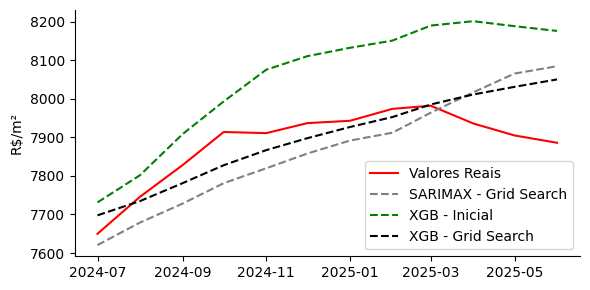

In [156]:
# Criar figura
plt.figure(figsize=(6, 3))

# Plotar valores reais
plt.plot(y_test.index, y_true_test, 'r-', label='Valores Reais')
plt.plot(y_test.index, y_pred_gs_rmse, '--',color='grey', label='SARIMAX - Grid Search')
plt.plot(y_test.index, y_pred_xgb_init_test, '--',color='green', label='XGB - Inicial')
plt.plot(y_test.index, y_pred_xgb_best_test, '--',color='black', label='XGB - Grid Search')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()

# 4. LSTM
Criado lags

Diferenciado features e target, aplicado ScalerMinMax

Foi testado 3 funções de ativação, diversos neuronios e mais de uma camada.

Porém melhor modelo, foi com ReLU e dropout, pois estava overffitando.

RMSE teste: 80.9009
RMSE train: 30.6661

In [210]:
# Definir a seed para reprodutibilidade
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

timesteps = 3

In [211]:
# Definiar dataframe
df_lstm = df_pre_pro.copy()

In [212]:
# Criando features com lag

lags =  3 # Lag

# Lag features
X_lstm = df_lstm.copy()
for col in X_lstm.columns.tolist():
    for lag in range(1, lags + 1):
        X_lstm[f'{col}_lag_{lag}'] = X_lstm[col].shift(lag)

#Difenreciar variaveis
X_lstm =X_lstm.diff()
X_lstm = X_lstm.dropna()

In [213]:
# Excluir variaivel orginais deixando apenas defasadas para evitar dataleakage
X_lstm = X_lstm.drop(columns=df_lstm.columns.tolist())

In [214]:
# Definir target
y_lstm = df_lstm['go_price'].diff().dropna()

# Igualar tamanho devido as perdas de amostra com defasagem
y_lstm = y_lstm.drop(pd.Timestamp("2014-02-01"))
y_lstm = y_lstm.drop(pd.Timestamp("2014-03-01"))
y_lstm = y_lstm.drop(pd.Timestamp("2014-04-01"))

In [215]:
# Verificação do tamanho dos DF
print(X_lstm.shape)
print(y_lstm.shape)

(134, 30)
(134,)


In [216]:
# Dividir em treino e teste
# Incluído 3 amostras a mais no teste por conta do timesteps
X_train_df, X_test_df = X_lstm.iloc[:-test_size], X_lstm.iloc[-test_size - timesteps:]
y_train_s, y_test_s = y_lstm.iloc[:-test_size], y_lstm.iloc[-test_size - timesteps:]

In [217]:
# Definir scalers para as variaveis
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [218]:
# Ajustar para array, aplicar scaler e retornar com dataframe em X
X_train_scaled = pd.DataFrame(
    scaler_X.fit_transform(X_train_df),
    columns=X_train_df.columns,
    index=X_train_df.index
)

# Ajustar para array, aplicar scaler, transforma em 1D e retorna série com y
y_train_scaled = pd.Series(
    scaler_y.fit_transform(y_train_s.values.reshape(-1,1)).flatten(),
    index=y_train_s.index
)


In [219]:
# Ajustar para array, aplicar scaler e retornar com dataframe em X
X_test_scaled = pd.DataFrame(
    scaler_X.transform(X_test_df),
    columns=X_test_df.columns,
    index=X_test_df.index
)

# Ajustar para array, aplicar scaler, transforma em 1D e retorna série com y
y_test_scaled = pd.Series(
    scaler_y.transform(y_test_s.values.reshape(-1,1)).flatten(),
    index=y_test_s.index
)

In [220]:
# Função de janelas deslisantes
# Cria os array no formato para alimentar o lstm
def create_lstm_windows(X_df, y_s, timesteps):
    X_list, y_list = [], []
    indices = []
    for i in range(timesteps, len(X_df)):
        X_list.append(X_df.iloc[i-timesteps:i].values)
        y_list.append(y_s.iloc[i])
        indices.append(X_df.index[i])
    X_arr = np.array(X_list)
    y_arr = np.array(y_list)
    return X_arr, y_arr, indices

In [239]:
# Aplicando a funçao
X_train_lstm, y_train_lstm, train_idx = create_lstm_windows(X_train_scaled, y_train_scaled, timesteps)
X_test_lstm, y_test_lstm, test_idx = create_lstm_windows(X_test_scaled, y_test_scaled, timesteps)

# Mostrar formato
print("X_train_lstm shape:", X_train_lstm.shape)  # (samples, timesteps, features)
print("y_train_lstm shape:", y_train_lstm.shape)

X_train_lstm shape: (119, 3, 30)
y_train_lstm shape: (119,)


In [257]:
# Estanciar modelo LSTM
model = Sequential([
    LSTM(150, activation = 'relu', input_shape=(timesteps, X_train_lstm.shape[2]),
    dropout=0.2),
    Dropout(0.2),
    Dense(1)
])

# Otimizador
model.compile(optimizer='adam')

# Treino
model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=12, verbose=1)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1064
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0445
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0381
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0344 
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0256
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192 
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0241 
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0262 
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0243 
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0232 
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0245 
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0245
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0242 
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0263 
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0238 
Epoch 16/

In [258]:
# Predição teste, inverte scaler
y_pred_scaled = model.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)

# Predição treino, inverte scaler
y_pred_scaled_train = model.predict(X_train_lstm)
y_pred_lstm_train = scaler_y.inverse_transform(y_pred_scaled_train)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


In [259]:
# Retornando diferenciação da predição
y_reconst1 = y_pred_lstm.cumsum()

# Invertendo scaler dos valores reais (teste e treino)
y_test_true = scaler_y.inverse_transform(y_test_lstm.reshape(-1,1))
y_train_true = scaler_y.inverse_transform(y_train_lstm.reshape(-1,1))

# Continuando o retorno da diferenciação
y_pred_lstm = y_reconst1 + y_true_test[0]

# Calculo do erro no treino
rmse_train = np.sqrt(mean_squared_error(y_train_true, y_pred_lstm_train))

# Calculo do erro no teste
rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_lstm))

#Mostrar valores do erro
print(f"RMSE teste: {rmse:.4f}")
print(f"RMSE train: {rmse_train:.4f}")

RMSE teste: 80.9009
RMSE train: 30.6661


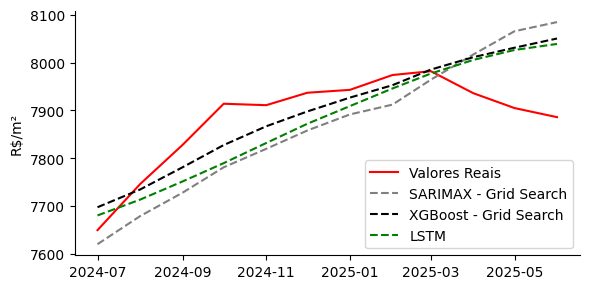

In [262]:
# Criar figura
plt.figure(figsize=(6, 3))

# Plotar valores reais
plt.plot(y_test.index, y_true_test, 'r-', label='Valores Reais')
plt.plot(y_test.index, y_pred_gs_rmse, '--',color='grey', label='SARIMAX - Grid Search')
plt.plot(y_test.index, y_pred_xgb_best_test, '--',color='black', label='XGBoost - Grid Search')
plt.plot(y_test.index, y_pred_lstm, '--',color='green', label='LSTM')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()

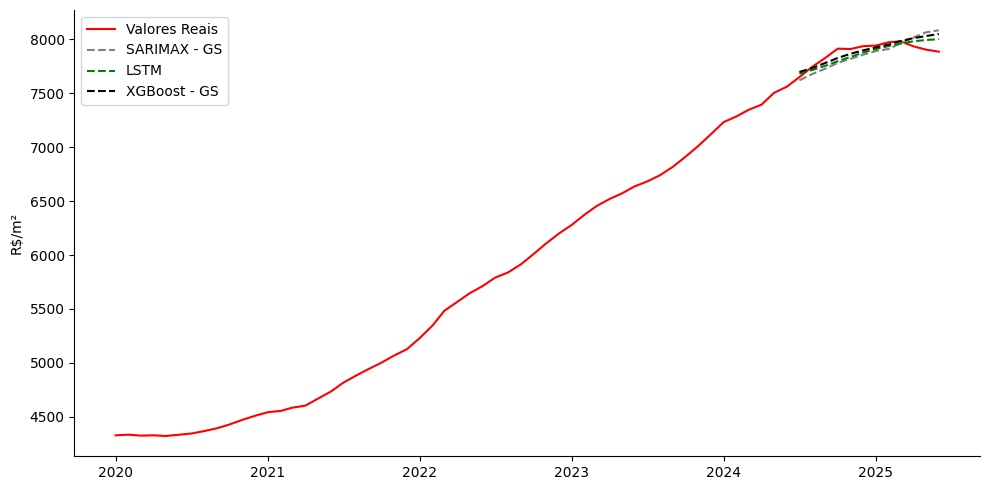

In [209]:
# Definir data inicial
start_date = "2020-01-01"

plt.figure(figsize=(10, 5))

# Série real a partir da data escolhida
plt.plot(y.loc[start_date:].index, y.loc[start_date:], 'r-', label='Valores Reais')

# Previsões a partir da mesma data
plt.plot(y_test.loc[start_date:].index, y_pred_gs_rmse[-len(y_test.loc[start_date:]):],
         '--', color='grey', label='SARIMAX - GS')
plt.plot(y_test.loc[start_date:].index, y_pred_lstm[-len(y_test.loc[start_date:]):],
         '--', color='green', label='LSTM')
plt.plot(y_test.loc[start_date:].index, y_pred_xgb_best_test[-len(y_test.loc[start_date:]):],
         '--', color='black', label='XGBoost - GS')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()